In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [2]:
#file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
file_path = '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp'
diagType = 'ocean_cobalt_fdet_100'

# yearmons = ['047601-048012', '048101-048512', '048601-049012', '049101-049512', '049601-050012']
yearmons = ['052101-052512','052601-053012']
years = ['0521-0525','0526-0530']

In [3]:
#plot_out='../plots_esm42/052422/esm42_prev_'
plot_out='../plots_esm42/060922/esm42_dev_060922_'

In [4]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
varlist=['fcadet_calc_100', 'fcadet_arag_100', 'flithdet_100', 'fsidet_100']
file_prefix = os.path.join(file_path, diagType, 'ts', 'annual', '5yr/')
files = [dot.join([file_prefix + diagType, yy, v, 'nc']) for v in varlist for yy in years]
#print(files)

In [5]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [6]:
caco3_molar_mass = 100.0869 # g/mol
carbon_molar_mass = 12.011 # g/mol
seconds_per_day = 86400.

In [7]:
ds = xr.open_mfdataset(files, combine='by_coords')
print(ds,grid)

<xarray.Dataset>
Dimensions:          (nv: 2, time: 10, xh: 720, yh: 576)
Coordinates:
  * nv               (nv) float64 1.0 2.0
  * time             (time) object 0521-07-02 12:00:00 ... 0530-07-02 12:00:00
  * xh               (xh) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * yh               (yh) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Data variables:
    fcadet_arag_100  (time, yh, xh) float32 dask.array<chunksize=(5, 576, 720), meta=np.ndarray>
    time_bnds        (time, nv) object dask.array<chunksize=(5, 2), meta=np.ndarray>
    average_T1       (time) object dask.array<chunksize=(5,), meta=np.ndarray>
    average_T2       (time) object dask.array<chunksize=(5,), meta=np.ndarray>
    average_DT       (time) timedelta64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    fcadet_calc_100  (time, yh, xh) float32 dask.array<chunksize=(5, 576, 720), meta=np.ndarray>
    flithdet_100     (time, yh, xh) float32 dask.array<chunksize=(5, 576, 720), meta=np.ndarray>


In [8]:
ds.flithdet_100

<xarray.DataArray 'flithdet_100' (time: 10, yh: 576, xh: 720)>
dask.array<concatenate, shape=(10, 576, 720), dtype=float32, chunksize=(5, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0521-07-02 12:00:00 ... 0530-07-02 12:00:00
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Attributes:
    units:          mol m-2 s-1
    long_name:      Lithogenic detritus sinking flux @ 100m
    cell_measures:  area: areacello
    cell_methods:   area:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT

# Calculate global totals

In [9]:
ds['fcadet_100']=ds.fcadet_arag_100 + ds.fcadet_calc_100

In [10]:
fcadet_calc_100 = (ds.fcadet_calc_100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fcadet_calc_100 = fcadet_calc_100 * carbon_molar_mass * seconds_per_day * 365.
print(str(np.round(fcadet_calc_100.values/1e15,2)) + ' Pg C y-1') # units of g C / yr

0.43 Pg C y-1


In [11]:
fcadet_arag_100 = (ds.fcadet_arag_100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fcadet_arag_100 = fcadet_arag_100 * carbon_molar_mass * seconds_per_day * 365.
print(str(np.round(fcadet_arag_100.values/1e15,2)) + ' Pg C y-1') # units of g C / yr

0.15 Pg C y-1


In [12]:
fcadet_100 = (ds.fcadet_100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fcadet_100 = fcadet_100 * carbon_molar_mass * seconds_per_day * 365.
print('Total calcium carbonate detritus flux at 100 m: ' + str(np.round(fcadet_100.values/1e15,2)) + ' Pg C y-1') # units of g C / yr

Total calcium carbonate detritus flux at 100 m: 0.58 Pg C y-1


In [13]:
fsidet_100 = (ds.fsidet_100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fsidet_100 = fsidet_100 * seconds_per_day * 365.
print('Silicon detritus flux at 100 m: ' + str(np.round(fsidet_100.values/1e12,2)) + ' Tmol y-1') # units of g C / yr

Silicon detritus flux at 100 m: 73.1 Tmol y-1


In [14]:
flithdet_100 = (ds.flithdet_100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
flithdet_100 = flithdet_100 * seconds_per_day * 365.
print('Lithogenic detritus flux at 100 m: ' + str(np.round(flithdet_100.values/1e15,2)) + ' Pmol y-1') # units of g C / yr

Lithogenic detritus flux at 100 m: 0.89 Pmol y-1


# Plot

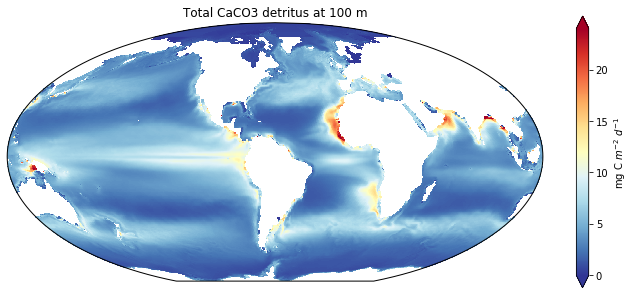

In [15]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300))

fcadet_100 = ds.fcadet_100.mean(dim='time') * carbon_molar_mass * 1000 * seconds_per_day

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, fcadet_100.values, transform=ccrs.PlateCarree(), vmin=0,vmax=24, cmap='RdYlBu_r')

lb=plt.colorbar(cs, extend='both')
lb.set_label('mg C $m^{-2}$ $d^{-1}$')
plt.title('Total CaCO3 detritus at 100 m')

fname = 'fcadet_100'
plt.savefig(plot_out+fname+'.png', dpi=300, bbox_inches='tight')

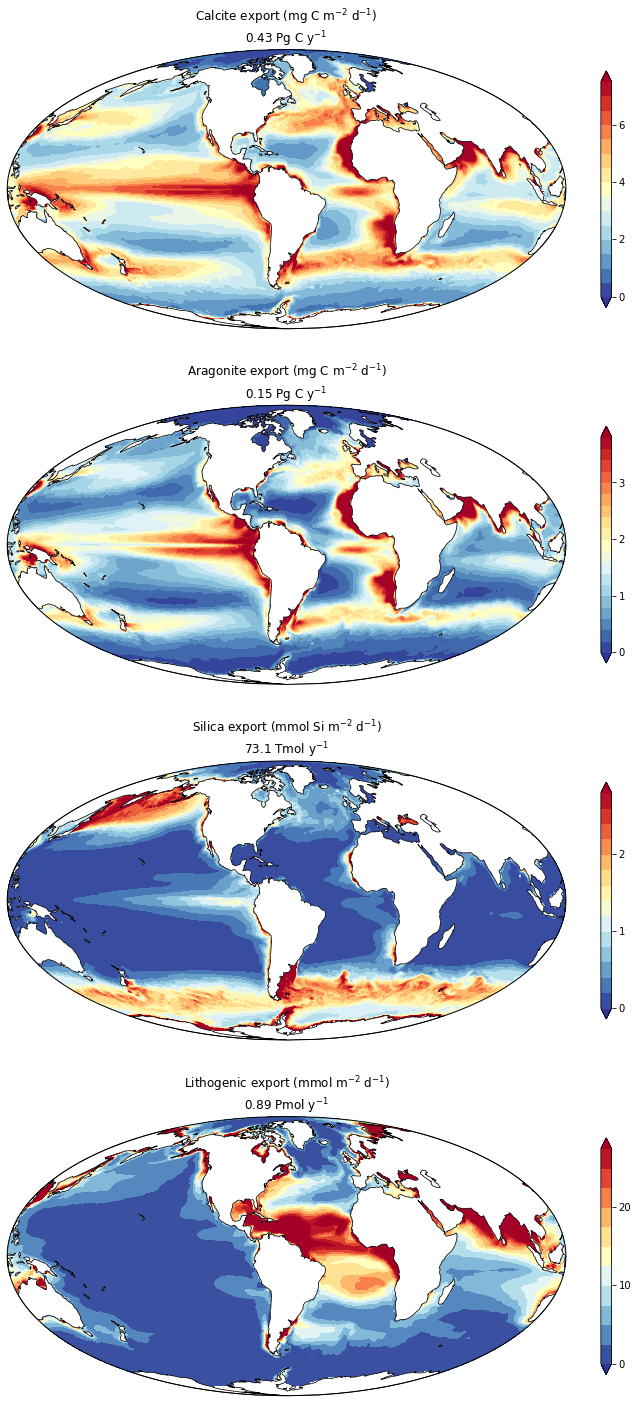

In [16]:
fig=plt.figure(figsize=(10,20))
gs=gridspec.GridSpec(4,1)

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Calcite export                                                          #
###########################################################################
cmin = 0; cmax = 8; cint = 0.5
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds.fcadet_calc_100.mean(dim='time') * carbon_molar_mass * seconds_per_day * 1000.
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Calcite export (mg C m$^{-2}$ d$^{-1}$)\n'+str(np.round(fcadet_calc_100.values/1e15,2)) + ' Pg C y$^{-1}$', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,2,4,6,8], shrink=0.75)

###########################################################################
# Aragonite export                                                        #
###########################################################################
cmin = 0; cmax = 4; cint = 0.2
levels=np.arange(cmin,cmax,cint)

i=1
ax[i]=plt.subplot(gs[i,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds.fcadet_arag_100.mean(dim='time') * carbon_molar_mass * seconds_per_day * 1000.
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Aragonite export (mg C m$^{-2}$ d$^{-1}$)\n'+str(np.round(fcadet_arag_100.values/1e15,2)) + ' Pg C y$^{-1}$', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,1,2,3,4], shrink=0.75)

###########################################################################
# Silica export                                                           #
###########################################################################
cmin = 0; cmax = 3; cint = 0.2;
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[i,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds.fsidet_100.mean(dim='time') * seconds_per_day * 1000.
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Silica export (mmol Si m$^{-2}$ d$^{-1}$)\n'+str(np.round(fsidet_100.values/1e12,2)) + ' Tmol y$^{-1}$', fontsize=fs)


cbar=plt.colorbar(cs[i], ticks=[0,1,2,3,4], shrink=0.75)


###########################################################################
# Lithogenic export                                                       #
###########################################################################
cmin = 0; cmax = 30; cint = 2.5;
levels=np.arange(cmin,cmax,cint)

i=3
ax[i]=plt.subplot(gs[i,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds.flithdet_100.mean(dim='time') * seconds_per_day * 1000.
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Lithogenic export (mmol m$^{-2}$ d$^{-1}$)\n'+str(np.round(flithdet_100.values/1e15,2)) + ' Pmol y$^{-1}$', fontsize=fs)


cbar=plt.colorbar(cs[i], ticks=[0,10,20,30], shrink=0.75)

plt.tight_layout()
fname = 'Mineral_export'
plt.savefig(plot_out+fname+'.png', dpi=300, bbox_inches='tight')